In [10]:
#France around Paris 
lat=48
lon=3

#todo: check units (tp and pr!), maybe add a unit conversion factor

def var_def(var,data):
    unit_converter=[]
    if data == 'era' and var == 'tas':
        var='t2m'
        unit_converter=1
    elif not data == 'era' and var == 'tas':
        var='tas'
        unit_converter=1
    
    elif data == 'era' and var == 'pr':
        var='tp'
        unit_converter=60*60*24
    elif not data == 'era' and var == 'pr':
        var='pr'
        unit_converter=60*60*24
    
    else:
        var=var

            
            
    return var,unit_converter

In [5]:
import numpy as np
import xarray as xr

import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [3]:
from dask.distributed import Client

In [4]:
client = Client(n_workers=4, threads_per_worker=1)
client

distributed.diskutils - INFO - Found stale lock file and directory '/usr/people/muntjewe/notebooks/VAREX-LE/dask-worker-space/worker-e4ekn52q', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 31.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33451,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 31.19 GiB
Comm: tcp://127.0.0.1:36309,Total threads: 1
Dashboard: http://127.0.0.1:42425/status,Memory: 7.80 GiB
Nanny: tcp://127.0.0.1:40679,


NameError: name 'client' is not defined

In [6]:
# this opens  DOY (1st oct (doy274) to 31 dec (doy 365) on 1 gridpoint
#TODO check whether this gridpoint is 100% land

# dit kan ik ook doen voor meerderen lat lons
def preprocess_OND(ds):
    '''keep only specified lat and lon for each file'''
    return ds.sel(lat=lat,lon=lon, method="nearest").isel(time=np.arange(274,365))
    #return ds.sel(lat=52,lon=5, method="nearest")
    

In [7]:
# this opens  DOY (1st april (doy91) to 31 july (doy 212) on 1 gridpoint
#TODO check whether this gridpoint is 100% land

# dit kan ik ook doen voor meerderen lat lons
def preprocess_AMJJ(ds):
    '''keep only specified lat and lon for each file'''
    return ds.sel(lat=lat,lon=lon, method="nearest").isel(time=np.arange(91,212))
    #return ds.sel(lat=52,lon=5, method="nearest")

In [11]:
# opening OND tas hxxx data
# here, we need to add 'concat_dim', namely 'ensemble' otherwise it's unclear what are the aligned time-dimensions

var='tasmax'
data='lentis'
var_OND,unit_converter_OND=var_def(var,data)

directory='/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/ec-earth/cmorised_by_var/'
scenario='hxxx'

files = f"{directory}{scenario}/day/{var}/*/{var}/gr/*/*.nc"

%time ds_hx_OND_tas = xr.open_mfdataset(files,preprocess=preprocess_OND, combine='nested',concat_dim='ens',chunks=-1, parallel=True)

CPU times: user 17.8 s, sys: 761 ms, total: 18.5 s
Wall time: 40.9 s


In [12]:
var_OND

'tasmax'

In [13]:
leeg = xr.ones_like(ds_hx_OND_tas[var_OND].dropna(dim='time'))
binary = leeg.where((273.15 < ds_hx_OND_tas[var_OND].dropna(dim='time')) & (ds_hx_OND_tas[var_OND].dropna(dim='time') < 283.15),0 )


In [31]:
%time ndays = int(binary.sum(dim='time')).compute()

KeyboardInterrupt: 

In [35]:
binary[1].compute()

<xarray.DataArray 'tas' (time: 0)>
array([], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 
    lat      float64 48.07
    lon      float64 2.812
    height   float64 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2022-04-04T10:01:20Z altered by CMOR: Treated scalar dime...

In [38]:
# opening OND tas hxxx data
# here, we need to add 'concat_dim', namely 'ensemble' otherwise it's unclear what are the aligned time-dimensions

var='pr'
data='lentis'
var_AMJJ,unit_converter_AMJJ=var_def(var,data)

directory='/usr/people/muntjewe/nobackup/nobackup_1/VAREXdata/ec-earth/cmorised_by_var/'
scenario='hxxx'

files = f"{directory}{scenario}/day/{var}/*/{var}/gr/*/*.nc"

%time ds_hx_AMJJ_pr = xr.open_mfdataset(files,preprocess=preprocess_AMJJ, combine='nested',concat_dim='ens',chunks=-1, parallel=True)

CPU times: user 15.7 s, sys: 984 ms, total: 16.7 s
Wall time: 52.1 s


In [61]:
block_mean_hx_pr = ds_hx_AMJJ_pr[var_AMJJ][1].groupby('time.year').mean('time') #.compute()

AttributeError: 'DataArrayGroupBy' object has no attribute 'plot'

In [60]:
block_mean_hx_pr.dropna(dim='year').compute()*unit_converter_AMJJ

<xarray.DataArray 'pr' (year: 1)>
array([2.19718715])
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
  * year     (year) int64 2001

In [54]:
block_mean_hx_pr[0].dropna(dim='year').compute()*unit_converter_AMJJ

<xarray.DataArray 'pr' (year: 1)>
array([2.14904805])
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
  * year     (year) int64 2000

In [50]:
block_mean_hx_pr

<xarray.DataArray 'pr' (ens: 799, year: 10)>
dask.array<transpose, shape=(799, 10), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
  * year     (year) int64 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
Dimensions without coordinates: ens

In [77]:
for i in range(0,100):
    unit_mm=ds_hx_AMJJ_pr[var_AMJJ][i]*unit_converter_AMJJ
    print(str(unit_mm.mean().compute()))
#unit_mm.plot()

<xarray.DataArray 'pr' ()>
array(2.14904812)
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
<xarray.DataArray 'pr' ()>
array(2.19718729)
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
<xarray.DataArray 'pr' ()>
array(1.23790632)
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
<xarray.DataArray 'pr' ()>
array(2.32473109)
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
<xarray.DataArray 'pr' ()>
array(1.78063646)
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
<xarray.DataArray 'pr' ()>
array(2.82364046)
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
<xarray.DataArray 'pr' ()>
array(2.21749969)
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
<xarray.DataArray 'pr' ()>
array(0.69655947)
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
<xarray.DataArray 'pr' ()>
array(2.99310882)
Coordinates:
    lat      float64 48.07
    lon      float6

In [71]:
unit_mm.mean().compute()

<xarray.DataArray 'pr' ()>
array(2.19718729)
Coordinates:
    lat      float64 48.07
    lon      float64 2.812

In [69]:
ds_hx_AMJJ_pr[var_AMJJ]

<xarray.DataArray 'pr' (ens: 799, time: 1210)>
dask.array<concatenate, shape=(799, 1210), dtype=float32, chunksize=(1, 1210), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-04-01T12:00:00 ... 2009-07-31T12:00:00
    lat      float64 48.07
    lon      float64 2.812
Dimensions without coordinates: ens
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          kg m-2 s-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2022-04-04T09:59:59Z altered by CMOR: Reordered dimension...

Text(0.5, 1.0, 'number of days between 0-10 degC in Oct-Dec is 47')

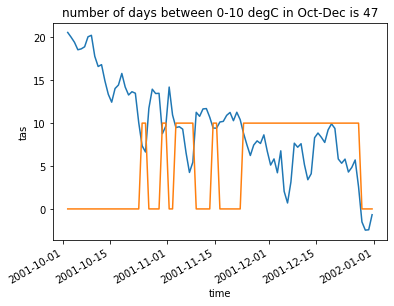

In [26]:
leeg = xr.ones_like(ds_hx_OND_tas[var_OND][1].dropna(dim='time'))
# keep zeros where conditions hold true, else put in 10
binary = leeg.where((273.15 < ds_hx_OND_tas[var_OND][1].dropna(dim='time')) & (ds_hx_OND_tas[var_OND][1].dropna(dim='time') < 283.15),0 )

#binary.plot()
degC = ds_hx_OND_tas[var_OND][1]-273.15
degC.dropna(dim='time').plot()
#plt.axhline(y = 0, color = 'r', linestyle = '-')
#plt.axhline(y = 10, color = 'r', linestyle = '-')

(binary*10).plot()

ndays = int(binary.sum().compute())
plt.title('number of days between 0-10 degC in Oct-Dec is '+str(ndays))


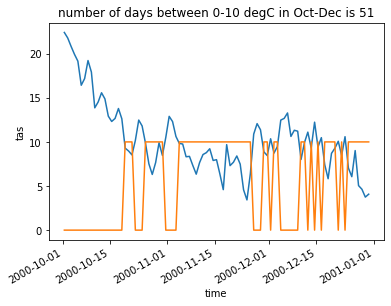

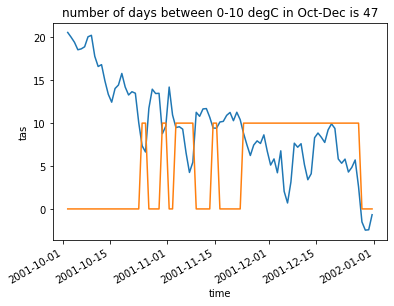

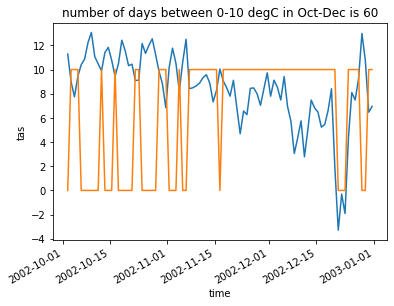

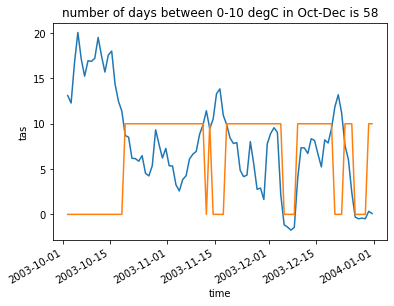

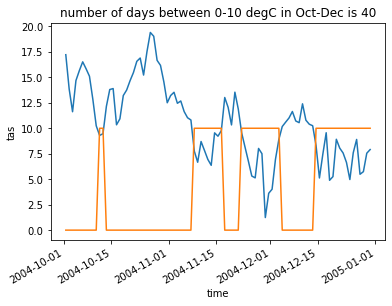

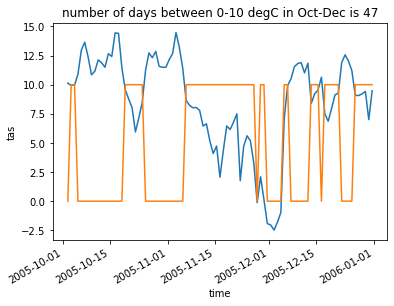

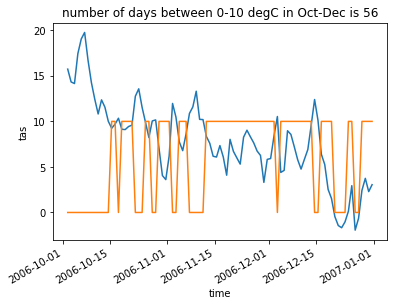

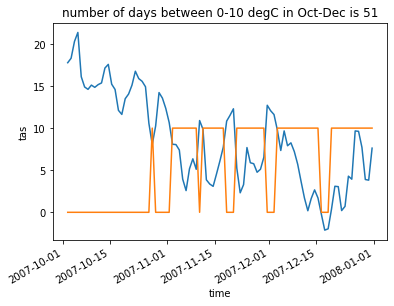

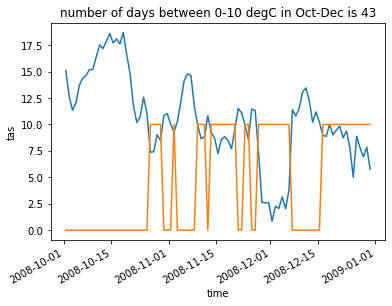

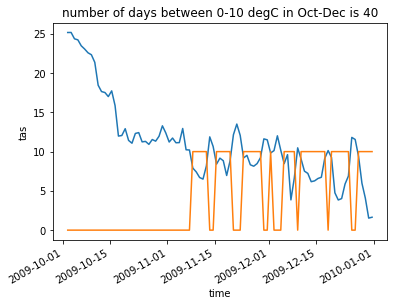

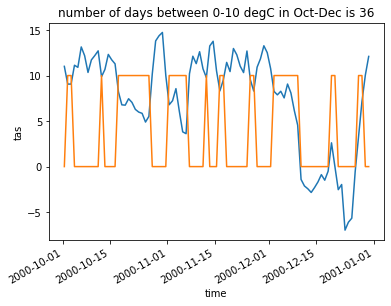

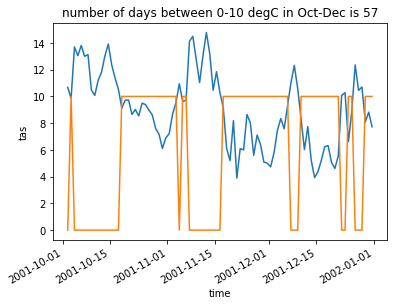

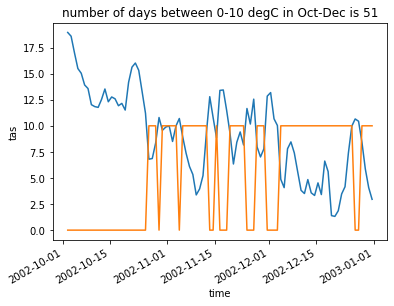

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


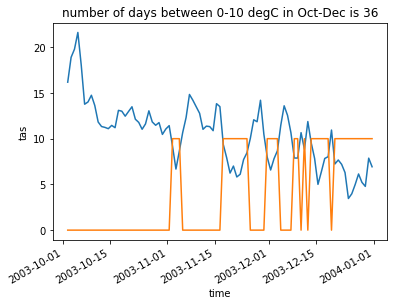

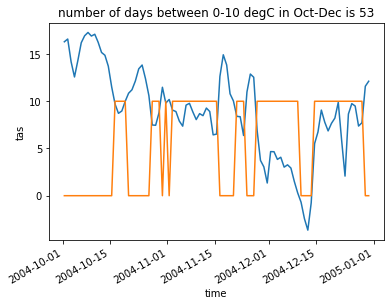

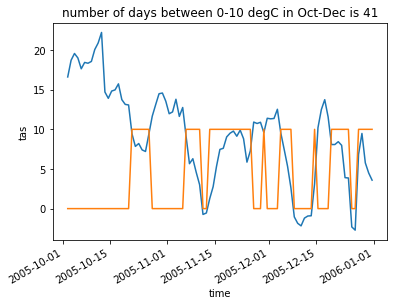

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


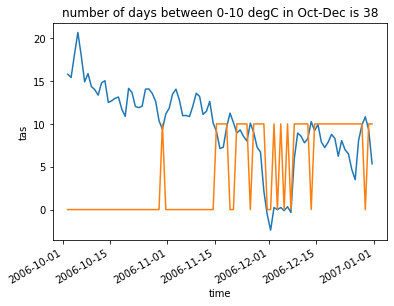

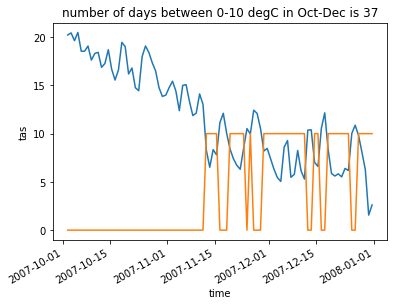

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


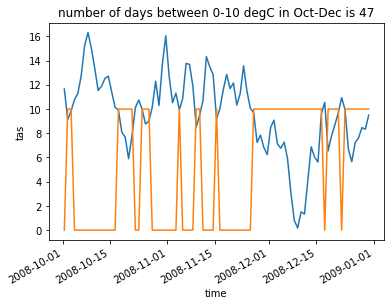

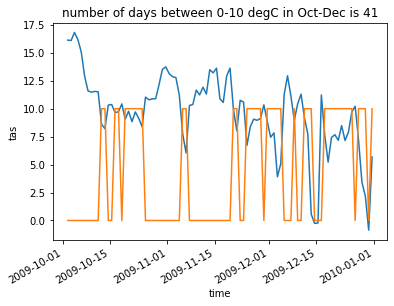

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


KeyboardInterrupt: 

In [28]:
for i in np.arange(0,100):
    

    leeg = xr.ones_like(ds_hx_OND_tas[var_OND][i].dropna(dim='time'))
    # keep zeros where conditions hold true, else put in 10
    binary = leeg.where((273.15 < ds_hx_OND_tas[var_OND][i].dropna(dim='time')) & (ds_hx_OND_tas[var_OND][i].dropna(dim='time') < 283.15), 0)

    #binary.plot()
    degC = ds_hx_OND_tas[var_OND][i]-273.15
    degC.dropna(dim='time').plot()
    plt.fill_between(x, 0, (binary*10))
    #plt.axhline(y = 0, color = 'r', linestyle = '-')
    #plt.axhline(y = 10, color = 'r', linestyle = '-')

    (binary*10).plot()
    plt.fill_between(x, 0, (binary*10))

    ndays = int(binary.sum().compute())
    plt.title('number of days between 0-10 degC in Oct-Dec is '+str(ndays))
    plt.show()

In [126]:
import pandas as pd


In [133]:
ds_hx_OND_tas #[var_OND].groupby('time.year')

<xarray.Dataset>
Dimensions:    (time: 910, ens: 800, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2000-10-01T12:00:00 ... 2009-12-31T12:00:00
    lat        float64 48.07
    lon        float64 2.812
    height     float64 2.0
Dimensions without coordinates: ens, bnds
Data variables:
    time_bnds  (ens, time, bnds) datetime64[ns] dask.array<chunksize=(1, 910, 2), meta=np.ndarray>
    lat_bnds   (ens, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds   (ens, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    tas        (ens, time) float32 dask.array<chunksize=(1, 910), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        CMIP
    branch_method:                      standard
    branch_time_in_child:               54786.0
    branch_time_in_parent:              54786.0
    comment:                            Production: Laura Muntjewerf & Thomas...
    ...                                 ...
    tracking_id:                        hdl:21.14100/57faf06f-2f6c-45df-b448-...
    variable_id:                        tas
    variant_info:                       The p5 label refers to the fact that ...
    variant_label:                      r1i1p5f1
    license:                            The VAREX model data produced by KNMI...
    cmor_version:                       3.5.0

In [171]:
ds_hx_OND_tas_months = ds_hx_OND_tas[var_OND].groupby('time.month')

In [172]:
ds_hx_OND_tas_months

DataArrayGroupBy, grouped over 'month'
3 groups with labels 10, 11, 12.

In [140]:
#ds_hx_OND_tas.groupby(pd.Grouper(freq='MS')).sum()

In [165]:
#ds_hx_OND_tas.groupby_bins(ds_hx_OND_tas.time.dt.month.isin([10, 11, 12]))

In [176]:
def SumAxis(darr, trange = (0+273.15,10+273.15)):
    return ((darr >= trange[0]) & (darr <= trange[1])).sum(axis=0)


#%timeit 
sum_months = SumAxis(ds_hx_OND_tas[var_OND][1])

In [178]:
sum_months.compute()

<xarray.DataArray 'tas' ()>
array(47)
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
    height   float64 2.0

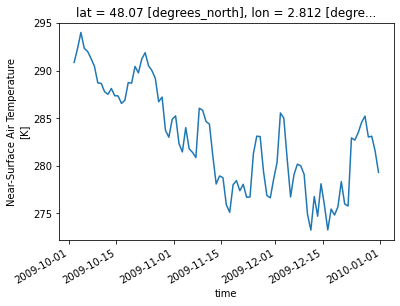

In [193]:
ds_hx_OND_tas[var_OND][799].plot()

In [188]:
#ds_hx_OND_tas[var_OND][1].plot()
aantal = (ds_hx_OND_tas[var_OND][1] >= trange[0]) & (ds_hx_OND_tas[var_OND][1] <= trange[1]).sum()

In [207]:
binary = ds_hx_OND_tas[var_OND][1].where(0+kelvin > ds_hx_OND_tas[var_OND][1] > 10+kelvin, 1, 0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

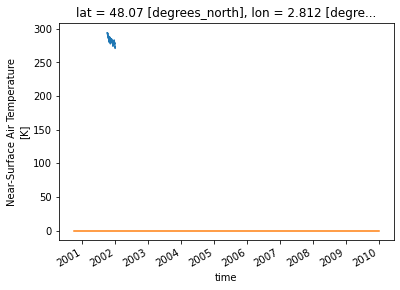

In [209]:
ds_hx_OND_tas[var_OND][1].plot()
leeg.plot()

In [279]:
leeg = xr.zeros_like(ds_hx_OND_tas[var_OND][1].dropna(dim='time'))

In [291]:
binary = leeg.where((273.15 < ds_hx_OND_tas[var_OND][1].dropna(dim='time')) & (ds_hx_OND_tas[var_OND][1].dropna(dim='time') < 283.15) , 10)

Text(0.5, 1.0, 'number of days between 0-10 degC in oct-Dec is 44')

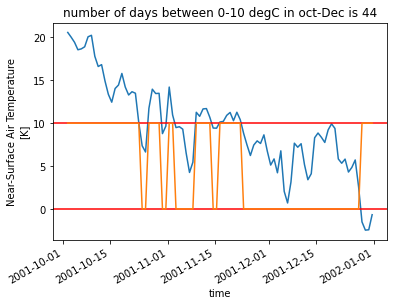

In [303]:
#binary.plot()
degC = ds_hx_OND_tas[var_OND][1]-273.15
degC.dropna(dim='time').plot()
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.axhline(y = 10, color = 'r', linestyle = '-')

binary.plot()

plt.title('number of days between 0-10 degC in Oct-Dec is '+str(ndays))

In [298]:
ndays = int(binary.sum().compute() /10)

In [299]:
ndays

44

In [252]:
binary.groupby('time.month').sum("time") #plot()

<xarray.DataArray 'tas' (ens: 800, month: 3)>
dask.array<transpose, shape=(800, 3), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
    height   float64 2.0
  * month    (month) int64 10 11 12
Dimensions without coordinates: ens

In [ ]:
.groupby('time.month').sum('month')

In [260]:
eerste_13 = binary[0:12].groupby('ens').sum('time').compute()

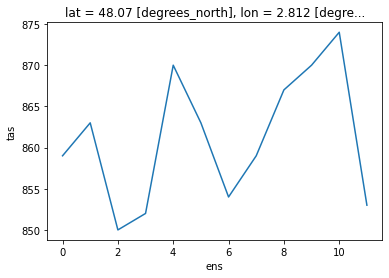

In [263]:
eerste_13.plot()

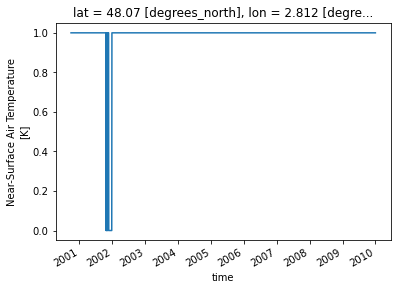

In [265]:
binary[1].plot()

In [277]:
ds_hx_OND_tas[var_OND][799].dropna(dim='time') #[1].compute()

<xarray.DataArray 'tas' (time: 91)>
dask.array<getitem, shape=(91,), dtype=float32, chunksize=(91,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2009-10-02T12:00:00 ... 2009-12-31T12:00:00
    lat      float64 48.07
    lon      float64 2.812
    height   float64 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2022-04-04T10:01:20Z altered by CMOR: Treated scalar dime...

In [166]:
#da_monthly  = ds_hx_OND_tas.resample('1M', on='time').sum()

In [167]:
#year_month_idx = pd.MultiIndex.from_arrays([ds_hx_OND_tas['time.year'], ds_hx_OND_tas['time.month']])
#ds_hx_OND_tas.coords['year_month'] = ('time', year_month_idx)
#ds_hx_OND_tas_monthly = ds_hx_OND_tas.groupby('year_month').sum()

In [168]:
#%time block_max_hx = ds_hx[var_lentis].groupby('time.season').max('time').compute()

# check the dates 1 oct - 31 dec
#ds_hx_OND_tas

In [169]:
#groups = ds_hx_OND_tas.groupby('time.year.time.month')

In [170]:
#for group in groups:
#    #group.groupby('time.year')
#    print(group)

In [21]:
block_max_hx = ds_hx_OND_tas[var_OND].groupby('time.season').max('time') #.compute()

In [96]:
def SumAxis(darr, trange = (0+273.15,10+273.15)):
    return ((darr >= trange[0]) & (darr <= trange[1])).sum(axis=0)


%timeit SumAxis(ds_hx_OND_tas[var_OND])

17 ms ± 32.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [103]:
%time restult3 = SumAxis(ds_hx_OND_tas[var_OND][1:3]).compute()

CPU times: user 107 ms, sys: 12.1 ms, total: 119 ms
Wall time: 2.17 s


In [112]:
ds_hx_OND_tas[var_OND][1:3]
#restult3 #.sum('time.year')

<xarray.DataArray 'tas' (ens: 2, time: 910)>
dask.array<getitem, shape=(2, 910), dtype=float32, chunksize=(1, 910), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-10-01T12:00:00 ... 2009-12-31T12:00:00
    lat      float64 48.07
    lon      float64 2.812
    height   float64 2.0
Dimensions without coordinates: ens
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2022-04-04T10:01:20Z altered by CMOR: Treated scalar dime...

In [114]:
910 / (31+30+30)

10.0

In [22]:
block_max_hx

<xarray.DataArray 'tas' (ens: 800, season: 2)>
dask.array<transpose, shape=(800, 2), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
    height   float64 2.0
  * season   (season) object 'DJF' 'SON'
Dimensions without coordinates: ens

In [36]:
block_max_hx2= ds_hx_OND_tas[var_OND].groupby('time.month').max('time').mean('month')

In [37]:
block_max_hx2

<xarray.DataArray 'tas' (ens: 800)>
dask.array<mean_agg-aggregate, shape=(800,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 48.07
    lon      float64 2.812
    height   float64 2.0
Dimensions without coordinates: ens

In [52]:
# what is done here: 
# - group by 'time.month' yields 800 time 3 months (oct, nov, dec). 
# - do the calculation: where temp is between 0 and 10, assign value 1, else assign value 0. 
# - sum up the 1's in the 3 months; this yields 800 values. 



#kelvin = 273.15
#block_max_hx2= ds_hx_OND_tas[var_OND].where(0+kelvin > block_max_hx2 > 10+kelvin, 1, 0)
#block_max_hx3=xr.where(0+kelvin > block_max_hx2 > 10+kelvin, 1, 0) #.sum('month')
#where(0+kelvin > ds_hx_OND_tas[var_OND] > 10+kelvin, 1, 0, axis='time').sum('month')
#xr.where(a>2, 1, 0)

In [71]:
#xr.where(0+kelvin > ds_hx_OND_tas[var_OND][1] > 10+kelvin, 1, 0)
#ds_hx_OND_tas[var_OND][1]
#& (df['Average temperature'] > 22.0)]
ds2 = ds_hx_OND_tas[var_OND][1][ ((ds_hx_OND_tas[var_OND][1] < 10+kelvin) & (ds_hx_OND_tas[var_OND][1] > 0+kelvin))]

In [72]:
array = ds2.sum().compute()

In [94]:
trange

(273.15, 283.15)

In [80]:
trange = (0+kelvin,10+kelvin)
result2=((ds_hx_OND_tas[var_OND][1] >= trange[0]) & (ds_hx_OND_tas[var_OND][1] <= trange[1]))

In [92]:
ds_hx_OND_tas[var_OND].sel(time='2000-10-02').plot()

KeyboardInterrupt: 

In [51]:
xr.where(0+kelvin > ds_hx_OND_tas[var_OND] > 10+kelvin, 1, 0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
%time result=xr.where(0+kelvin > ds_hx_OND_tas[var_OND] > 10+kelvin, 1, 0).groupby('time.month').sum('month')